## Creating a MLP model for gait analysis


In [18]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [19]:
!pip install imblearn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [20]:
import numpy as np
import importlib
import fncs_helper
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from torchsummary import summary
import os
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from imblearn.over_sampling import BorderlineSMOTE


importlib.reload(fncs_helper)

import json
with open('Settings.json') as f:
    S = json.load(f)
    dataFolder = S['dataFolder']

### Loading the Data and Features

First, we define a helper function to load the data and compute the features. The labels are extracted by following a similar procedure for window extraction and assigning the mode.

Extracting the features for the training data and splitting it into training / validation.

In [21]:
# Specifying the data directory
dirTrain = 'Train/'

# Specifying some parameters for the feature extraction
timeStep = 1
winSz = 2

# Specifying IDs for training and validation sets
valIDs = [2,11,25]
trainIDs = list(set(np.array(range(25))+1).difference(valIDs))

# Recovering the features and labels
xTrain, yTrain = fncs_helper.loadFeatures(dirTrain,winSz,timeStep,trainIDs)
xVal, yVal = fncs_helper.loadFeatures(dirTrain,winSz,timeStep,valIDs)

# Saving validation set
np.savetxt('Data/val.x.csv',xVal,delimiter=',')
np.savetxt('Data/val.y.csv',yVal,fmt='%d')

### Training MLPs

Our main objective will be to do some optimization on the architecture. Let us begin by defining some constant parameters.

In [22]:
# Defining the input and output size of the model
INPUTSIZE = 14
OUTPUTSIZE = 4

# Specify the device that you will use here.

# This works if you are just using your local machine with no GPU
#DEVICE = 'cpu'

# This works if youare using the Jupyter Hub
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
DEVICE = 'cpu'

#### 1-Layer MLP

Our first MLP model is a single layer model. In this case, we don't have a choice on the number of neurons since the dimensions of the layer are pre-determined by the input and ouput.

We begin by defining the neural network class.

In [23]:
X_train, X_val, y_train, y_val = train_test_split(
        xTrain, yTrain,          # ← these two arrays already exist in the cell
        test_size=0.20,
        stratify=yTrain,
        random_state=38)

print("Before SMOTE:", np.bincount(y_train))

counts = np.bincount(y_train)
target = counts.max() 
sm = BorderlineSMOTE(kind='borderline-2', sampling_strategy={3: int(1.1*target)} ,random_state=38)

X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

print("After  SMOTE:", np.bincount(y_train_sm))


Before SMOTE: [15754   878  1144  2901]
After  SMOTE: [15754   878  1144 17329]


In [24]:
# Defining the neural network architecture
class Net1(nn.Module):
    def __init__(self, noNeurons=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(INPUTSIZE, noNeurons),
            nn.BatchNorm1d(noNeurons),
            nn.ReLU(),
            nn.Dropout(0.30),

            nn.Linear(noNeurons, 4)        # 4 classes
        )
    def forward(self, x): return self.net(x)

Defining and training a model.

In [25]:
# Reloading the settings in case you end up modifying them
with open('Settings.json') as f:
    S = json.load(f)
    
# Number of epochs specified in the settings file
epochs = S['1Layer']['epochs']

# The weights for cross-entropy specified in the settings file
weights = S['1Layer']['weights']


In [26]:
importlib.reload(fncs_helper)

# Defining the Model
model = Net1().to(DEVICE)
M1 = fncs_helper.NetWrapper(model,DEVICE,epochs,weights)

# Displaying a summary
summary(M1.model,(INPUTSIZE,))

# Training the model
M1.fit(X_train_sm,y_train_sm, X_val, y_val)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           1,920
       BatchNorm1d-2                  [-1, 128]             256
              ReLU-3                  [-1, 128]               0
           Dropout-4                  [-1, 128]               0
            Linear-5                    [-1, 4]             516
Total params: 2,692
Trainable params: 2,692
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


/home/codespace/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/home/codespace/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate you

Performance on training and validation sets.

RESULTS:

Training:  Acc = 0.797
Training:  BalAcc = 0.878
Validation: Acc = 0.797
Validation: BalAcc = 0.844


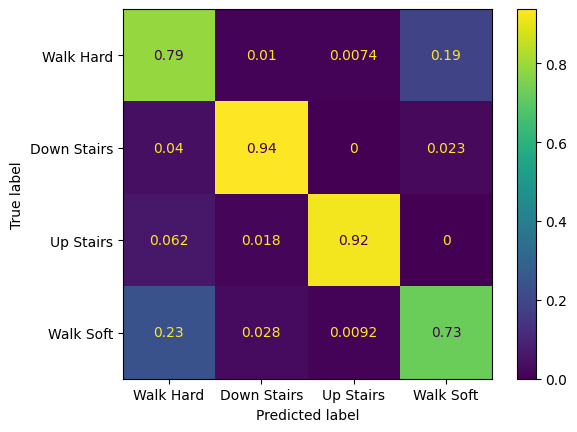

In [27]:
yTrainHat1 = M1.predict(xTrain)
yValHat1 = M1.predict(xVal)

print('RESULTS:\n')
fncs_helper.summaryPerf(yTrain,yTrainHat1,yVal,yValHat1)

# Saving the predictions since they will be used for testing later
np.savetxt('Data/1LayerPred.y.csv',yValHat1,fmt='%d')

# Saving the model
model_scripted = torch.jit.script(model)
model_scripted.save('Models/model_1Layer.pt')

We can tune the hyper-parameters specified in `Settings.json` for the 1-layer model so your performance exceeds 0.75 on balanced accuracy. We can run the script below to test the model accuracy and if it exceeds, it will pass. Currently, The model is optimially tuned at 0.844 balanced accuracy. 

In [28]:
!python -m pytest fnc_1Layer_test.py

============================= test session starts ==============================
platform linux -- Python 3.12.1, pytest-8.3.5, pluggy-1.5.0
rootdir: /workspaces/gaitMLP
plugins: anyio-4.9.0
collected 1 item                                                               

fnc_1Layer_test.py .                                                     [100%]

============================== 1 passed in 1.61s ===============================


#### 2-Layer MLP

In this case, we have a choice on the number of neurons for the hidden layer. Note that in this section, we are using the optimal number of epochs and weights found on the previous section.

In [29]:
# Defining the neural network architecture
class Net2(nn.Module):
    def __init__(self, noNeurons=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(INPUTSIZE, noNeurons),
            nn.BatchNorm1d(noNeurons),
            nn.ReLU(),
            nn.Dropout(0.30),

            nn.Linear(noNeurons, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.30),

            nn.Linear(32, 4)
        )
    def forward(self, x): return self.net(x)

Defining and training the model with an arbitrary number of neurons.

In [30]:
# Reloading the settings in case you end up modifying them
with open('Settings.json') as f:
    S = json.load(f)
    
# Number of epochs specified in the settings file
epochs = S['2Layer']['epochs']

# The weights for cross-entropy specified in the settings file
weights = S['2Layer']['weights']

# The number of neurosn in the hiddne layers
noNeurons = S['2Layer']['noNeurons']

In [31]:
# Defining the Model
model = Net2(noNeurons).to(DEVICE)
M2 = fncs_helper.NetWrapper(model,DEVICE,epochs,weights)

# Displaying a summary
summary(M2.model,(INPUTSIZE,))

# Training the model
M2.fit(X_train_sm,y_train_sm, X_val, y_val)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]             960
       BatchNorm1d-2                   [-1, 64]             128
              ReLU-3                   [-1, 64]               0
           Dropout-4                   [-1, 64]               0
            Linear-5                   [-1, 32]           2,080
       BatchNorm1d-6                   [-1, 32]              64
              ReLU-7                   [-1, 32]               0
           Dropout-8                   [-1, 32]               0
            Linear-9                    [-1, 4]             132
Total params: 3,364
Trainable params: 3,364
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.02
-----------------------------------------------

/home/codespace/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/home/codespace/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate you

Performance of predictions using the training and validation set.

RESULTS:

Training:  Acc = 0.796
Training:  BalAcc = 0.883
Validation: Acc = 0.791
Validation: BalAcc = 0.846


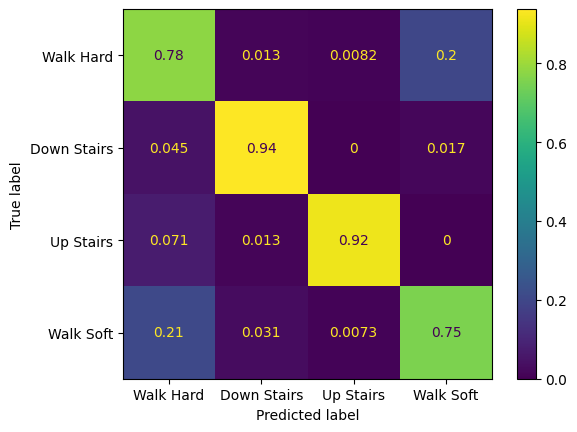

In [32]:
yTrainHat2 = M2.predict(xTrain)
yValHat2 = M2.predict(xVal)

print('RESULTS:\n')
fncs_helper.summaryPerf(yTrain,yTrainHat2,yVal,yValHat2)

# Saving the predictions since they will be used for testing later
np.savetxt('Data/2LayerPred.y.csv',yValHat2,fmt='%d')

# Saving the model
model_scripted = torch.jit.script(model)
model_scripted.save('Models/model_2Layer.pt')

We can tune the hyper-parameters specified in `Settings.json` for the 2-layer model so that the performance exceeds 0.82 on balanced accuracy.Currently, The model is optimially tuned at 0.846 balanced accuracy.

In [33]:
!python -m pytest fnc_2Layer_test.py

============================= test session starts ==============================
platform linux -- Python 3.12.1, pytest-8.3.5, pluggy-1.5.0
rootdir: /workspaces/gaitMLP
plugins: anyio-4.9.0
collected 1 item                                                               

fnc_2Layer_test.py .                                                     [100%]

============================== 1 passed in 0.99s ===============================


#### 3-Layer MLP

When defining a 3-layer MLP, we have a choice for two of the neurons. We will set the first hidden layer to have the same number of layers as the optimal value found from the previous sections. We will also reuse the weights and number of epochs.

In [34]:
# Defining the neural network architecture
class Net3(nn.Module):
  def __init__(self,noNeurons1,noNeurons2):
    super(Net3, self).__init__()
    self.linear_relu_stack = nn.Sequential(
        
        nn.LazyLinear(noNeurons1),
        nn.BatchNorm1d(noNeurons1),
        nn.ReLU(),
        nn.Dropout(0.30),
        nn.Linear(noNeurons1,noNeurons2),
        nn.BatchNorm1d(noNeurons2),
        nn.ReLU(),
        nn.Dropout(0.30),        
        nn.Linear(noNeurons2,OUTPUTSIZE),
        
    )

  def forward(self, x):
    logits = self.linear_relu_stack(x)
    return logits

In [35]:
# Reloading the settings in case you end up modifying them
with open('Settings.json') as f:
    S = json.load(f)
    
# Number of epochs specified in the settings file
epochs = S['3Layer']['epochs']

# The weights for cross-entropy specified in the settings file
weights = S['3Layer']['weights']

# The number of neurosn in the hiddne layers
noNeurons1 = S['3Layer']['noNeurons1']
noNeurons2 = S['3Layer']['noNeurons2']

In [36]:
# Defining the Model

model = Net3(noNeurons1,noNeurons2).to(DEVICE)
M3 = fncs_helper.NetWrapper(model,DEVICE,epochs,weights)

# Displaying a summary
summary(M3.model,(INPUTSIZE,))

# Training the model
M3.fit(X_train_sm,y_train_sm, X_val, y_val)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]           3,840
       BatchNorm1d-2                  [-1, 256]             512
              ReLU-3                  [-1, 256]               0
           Dropout-4                  [-1, 256]               0
            Linear-5                   [-1, 64]          16,448
       BatchNorm1d-6                   [-1, 64]             128
              ReLU-7                   [-1, 64]               0
           Dropout-8                   [-1, 64]               0
            Linear-9                    [-1, 4]             260
Total params: 21,188
Trainable params: 21,188
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.08
Estimated Total Size (MB): 0.09
---------------------------------------------

/home/codespace/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/home/codespace/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate you

Performance of predictions using the training and validation set.

RESULTS:

Training:  Acc = 0.822
Training:  BalAcc = 0.910
Validation: Acc = 0.816
Validation: BalAcc = 0.861


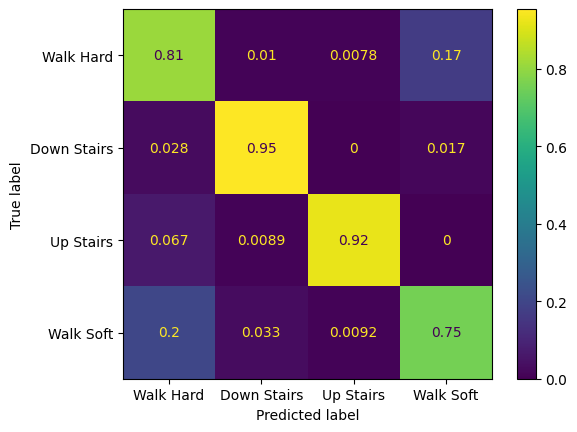

In [37]:
yTrainHat3 = M3.predict(xTrain)
yValHat3 = M3.predict(xVal)

print('RESULTS:\n')
fncs_helper.summaryPerf(yTrain,yTrainHat3,yVal,yValHat3)

# Saving the predictions since they will be used for testing later
np.savetxt('Data/3LayerPred.y.csv',yValHat3,fmt='%d')

# Saving the model
model_scripted = torch.jit.script(model)
model_scripted.save('Models/model_3Layer.pt')

We can tune the hyper-parameters specified in `Settings.json` for the 3-layer model so that the performance exceeds 0.82 on balanced accuracy. Currently, The model is optimially tuned at 0.861 balanced accuracy.

In [38]:
!python -m pytest fnc_3Layer_test.py

============================= test session starts ==============================
platform linux -- Python 3.12.1, pytest-8.3.5, pluggy-1.5.0
rootdir: /workspaces/gaitMLP
plugins: anyio-4.9.0
collected 1 item                                                               

fnc_3Layer_test.py .                                                     [100%]

============================== 1 passed in 1.03s ===============================
